<a href="https://colab.research.google.com/github/janturahaman/Facial_expression/blob/main/Comparative_Study_facial_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, add
from tensorflow.keras.utils import plot_model

In [ ]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Facial_expression/fer2013.csv/fer2013.csv',names=names, na_filter=False)
df = df.iloc[1:]
df.head()

,emotion,pixels,usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
import cv2
import os

dataset_directory = '/content/drive/MyDrive/Facial_expression/New_Data/'

image_files = os.listdir(dataset_directory)

grayscale_images = []

for file_name in image_files:
    file_path = os.path.join(dataset_directory, file_name)
    image = cv2.imread(file_path, 0)
    grayscale_images.append(image)

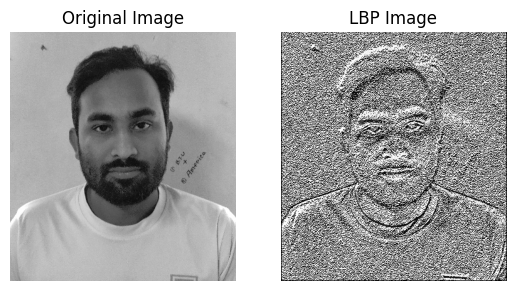

In [ ]:

image = cv2.imread('/content/drive/MyDrive/Facial_expression/New_Data/28.jpg', 0)
radius = 1
neighbors = 8
lbp = np.zeros_like(image)
height, width = image.shape
for y in range(radius, height - radius):
    for x in range(radius, width - radius):
        center = image[y, x]
        code = 0
        for i in range(neighbors):
            angle = 2 * np.pi * i / neighbors
            x_i = int(x + radius * np.cos(angle))
            y_i = int(y + radius * np.sin(angle))
            if image[y_i, x_i] >= center:
                code |= (1 << i)
        lbp[y, x] = code
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap='gray')
plt.title('LBP Image')
plt.axis('off')

plt.show()

In [ ]:
def get_train_data(df):
    x = []

    train = df['pixels'].to_numpy()

    for i in range(len(train)):
        x.append(train[i].split(' '))

    x = np.array(x)
    x = x.astype('float32').reshape(len(train), 48, 48, 1)

    return x

In [ ]:
train = get_train_data(df)
labels = df['emotion'].to_numpy().astype('int')

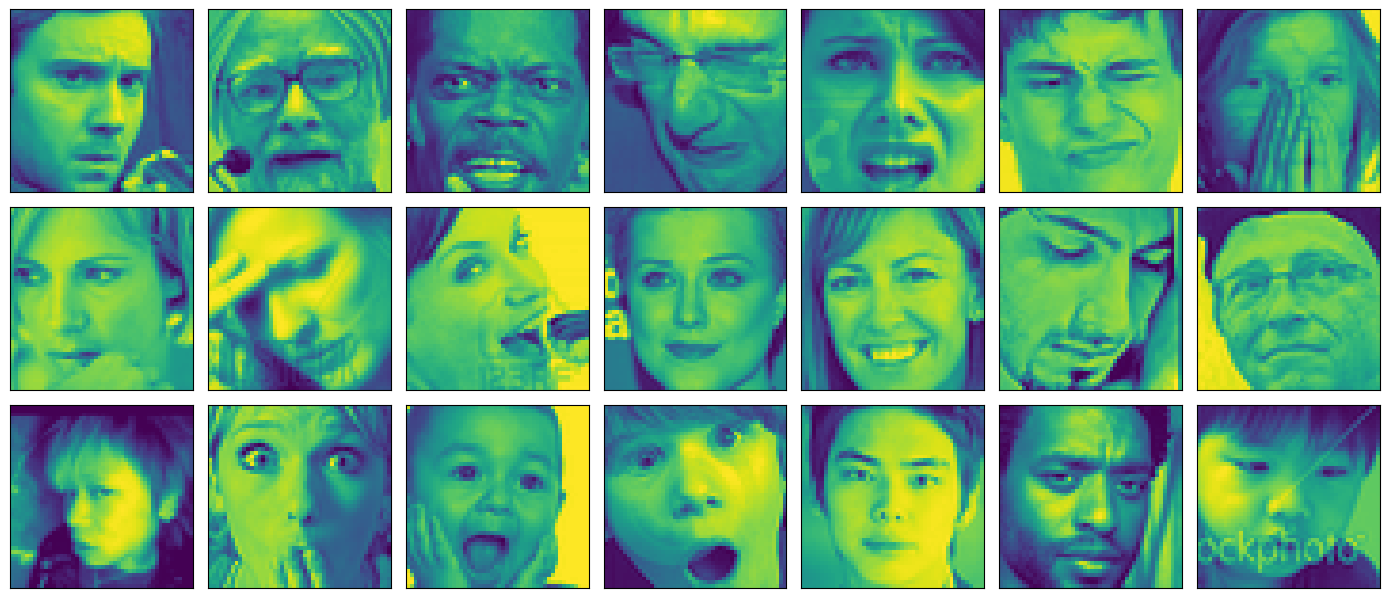

In [ ]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.1, random_state=42)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
X_train.shape

(32298, 48, 48, 1)

In [ ]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
time_callback_vgg = TimeHistory()
time_callback_incep = TimeHistory()
time_callback_resid = TimeHistory()
time_callback_cnn =TimeHistory()

In [ ]:
basemodel = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 4
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Flatten and fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


In [ ]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss ='categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [ ]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='max')

In [ ]:
basemodel.fit(X_train,y_train,epochs=30,validation_split=.2,callbacks=call_back)

Epoch 1/30
808/808 [==============================] - ETA: 0s - loss: 1.4404 - accuracy: 0.4459
Epoch 1: val_accuracy improved from 0.30774 to 0.42817, saving model to checkpoint/best_model.h5
808/808 [==============================] - 39s 48ms/step - loss: 1.4404 - accuracy: 0.4459 - val_loss: 1.5006 - val_accuracy: 0.4282
Epoch 2/30
808/808 [==============================] - ETA: 0s - loss: 1.3562 - accuracy: 0.4830
Epoch 2: val_accuracy did not improve from 0.42817
808/808 [==============================] - 35s 43ms/step - loss: 1.3562 - accuracy: 0.4830 - val_loss: 2.2357 - val_accuracy: 0.3077
Epoch 3/30
807/808 [============================>.] - ETA: 0s - loss: 1.2929 - accuracy: 0.5081
Epoch 3: val_accuracy improved from 0.42817 to 0.49133, saving model to checkpoint/best_model.h5
808/808 [==============================] - 36s 45ms/step - loss: 1.2929 - accuracy: 0.5081 - val_loss: 1.3469 - val_accuracy: 0.4913
Epoch 4/30
808/808 [==============================] - ETA: 0s - loss

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

y_pred = np.argmax(basemodel.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score:", f1)

113/113 [==============================] - 2s 15ms/step
F1 score: 0.6187408839981577


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       498
           1       0.62      0.44      0.52        52
           2       0.56      0.43      0.48       545
           3       0.77      0.84      0.80       881
           4       0.50      0.54      0.52       588
           5       0.75      0.76      0.75       414
           6       0.60      0.57      0.58       611

    accuracy                           0.62      3589
   macro avg       0.61      0.58      0.59      3589
weighted avg       0.62      0.62      0.62      3589



113/113 [==============================] - 2s 15ms/step


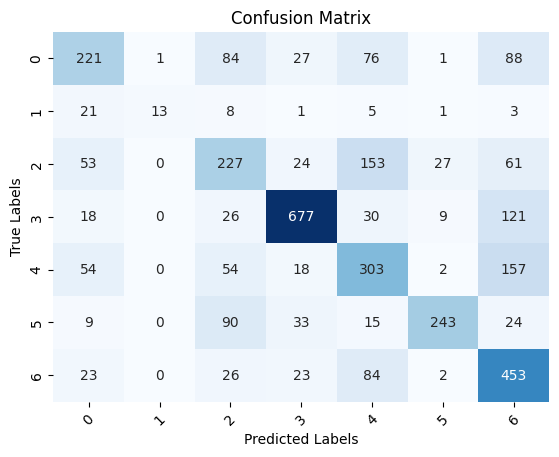

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(basemodel.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

labels = ['Class 1', 'Class 2', 'Class 3']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
visible = Input(shape=(48, 48, 1))

layer = Conv2D(64, (3, 3), padding='same', activation='relu')(visible)
layer = Conv2D(64, (3, 3), padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2), strides=(2, 2))(layer)

layer = Conv2D(128, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(128, (3, 3), padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2), strides=(2, 2))(layer)

layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = Conv2D(256, (3, 3), padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2), strides=(2, 2))(layer)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)
model_cnn = Model(inputs=visible, outputs=layer)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history_cnn=model_cnn.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
908/909 [============================>.] - ETA: 0s - loss: 1.8415 - accuracy: 0.2494
Epoch 1: val_accuracy did not improve from 0.60248
909/909 [==============================] - 49s 19ms/step - loss: 1.8414 - accuracy: 0.2494 - val_loss: 1.7910 - val_accuracy: 0.2771
Epoch 2/30
907/909 [============================>.] - ETA: 0s - loss: 1.6854 - accuracy: 0.3230
Epoch 2: val_accuracy did not improve from 0.60248
909/909 [==============================] - 18s 19ms/step - loss: 1.6852 - accuracy: 0.3230 - val_loss: 1.5237 - val_accuracy: 0.4211
Epoch 3/30
907/909 [============================>.] - ETA: 0s - loss: 1.4457 - accuracy: 0.4404
Epoch 3: val_accuracy did not improve from 0.60248
909/909 [==============================] - 18s 19ms/step - loss: 1.4456 - accuracy: 0.4405 - val_loss: 1.3768 - val_accuracy: 0.4827
Epoch 4/30
907/909 [============================>.] - ETA: 0s - loss: 1.3195 - accuracy: 0.4944
Epoch 4: val_accuracy did not improve from 0.60248
909/909 [====

113/113 [==============================] - 1s 6ms/step


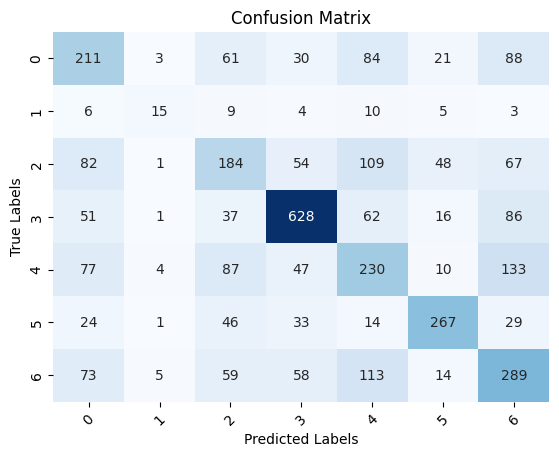

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model_cnn.predict(X_test), axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

labels = ['Class 1', 'Class 2', 'Class 3']

fig, ax = plt.subplots()

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.42      0.41       498
           1       0.50      0.29      0.37        52
           2       0.38      0.34      0.36       545
           3       0.74      0.71      0.72       881
           4       0.37      0.39      0.38       588
           5       0.70      0.64      0.67       414
           6       0.42      0.47      0.44       611

    accuracy                           0.51      3589
   macro avg       0.50      0.47      0.48      3589
weighted avg       0.51      0.51      0.51      3589



In [ ]:
from sklearn.metrics import f1_score
import numpy as np

y_pred = np.argmax(model_cnn.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score:", f1)


113/113 [==============================] - 1s 6ms/step
F1 score: 0.5097684103998837


In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [ ]:
visible = Input(shape=(48, 48, 1))
layer = vgg_block(visible, 64, 2)
layer = vgg_block(layer, 128, 2)
layer = vgg_block(layer, 256, 4)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_vgg = Model(inputs=visible, outputs=layer)
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_vgg=model_vgg.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
907/909 [============================>.] - ETA: 0s - loss: 1.8485 - accuracy: 0.2496
Epoch 1: val_accuracy did not improve from 0.60248
909/909 [==============================] - 23s 21ms/step - loss: 1.8484 - accuracy: 0.2496 - val_loss: 1.8152 - val_accuracy: 0.2480
Epoch 2/30
907/909 [============================>.] - ETA: 0s - loss: 1.7963 - accuracy: 0.2590
Epoch 2: val_accuracy did not improve from 0.60248
909/909 [==============================] - 17s 19ms/step - loss: 1.7963 - accuracy: 0.2589 - val_loss: 1.7871 - val_accuracy: 0.2529
Epoch 3/30
907/909 [============================>.] - ETA: 0s - loss: 1.5258 - accuracy: 0.4044
Epoch 3: val_accuracy did not improve from 0.60248
909/909 [==============================] - 18s 20ms/step - loss: 1.5253 - accuracy: 0.4046 - val_loss: 1.3793 - val_accuracy: 0.4783
Epoch 4/30
908/909 [============================>.] - ETA: 0s - loss: 1.3076 - accuracy: 0.4960
Epoch 4: val_accuracy did not improve from 0.60248
909/909 [====

113/113 [==============================] - 1s 7ms/step


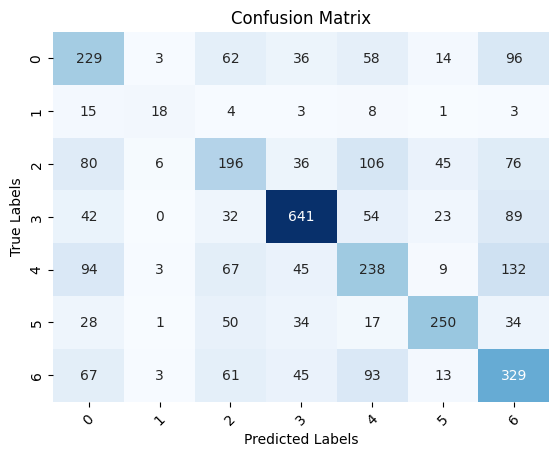

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model_vgg.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
labels = ['Class 1', 'Class 2', 'Class 3']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.46      0.43       498
           1       0.53      0.35      0.42        52
           2       0.42      0.36      0.39       545
           3       0.76      0.73      0.74       881
           4       0.41      0.40      0.41       588
           5       0.70      0.60      0.65       414
           6       0.43      0.54      0.48       611

    accuracy                           0.53      3589
   macro avg       0.52      0.49      0.50      3589
weighted avg       0.54      0.53      0.53      3589



In [ ]:
from sklearn.metrics import f1_score
import numpy as np
y_pred = np.argmax(model_vgg.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score:", f1)

113/113 [==============================] - 1s 6ms/step
F1 score: 0.5316850519446001


In [ ]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [ ]:
visible = Input(shape=(48, 48, 1))
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_inception = Model(inputs=visible, outputs=layer)
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_inception=model_inception.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
909/909 [==============================] - ETA: 0s - loss: 25.7129 - accuracy: 0.2697
Epoch 1: val_accuracy did not improve from 0.60248
909/909 [==============================] - 71s 71ms/step - loss: 25.7129 - accuracy: 0.2697 - val_loss: 1.7627 - val_accuracy: 0.2885
Epoch 2/30
908/909 [============================>.] - ETA: 0s - loss: 1.6411 - accuracy: 0.3501
Epoch 2: val_accuracy did not improve from 0.60248
909/909 [==============================] - 59s 65ms/step - loss: 1.6412 - accuracy: 0.3501 - val_loss: 1.7399 - val_accuracy: 0.3204
Epoch 3/30
908/909 [============================>.] - ETA: 0s - loss: 1.4623 - accuracy: 0.4309
Epoch 3: val_accuracy did not improve from 0.60248
909/909 [==============================] - 60s 66ms/step - loss: 1.4623 - accuracy: 0.4309 - val_loss: 1.9553 - val_accuracy: 0.2830
Epoch 4/30
908/909 [============================>.] - ETA: 0s - loss: 1.2970 - accuracy: 0.5080
Epoch 4: val_accuracy did not improve from 0.60248
909/909 [==

113/113 [==============================] - 3s 23ms/step


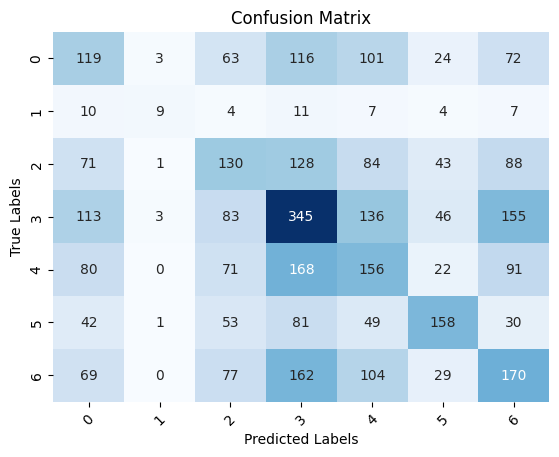

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model_inception.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
labels = ['Class 1', 'Class 2', 'Class 3']
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.24      0.24       498
           1       0.53      0.17      0.26        52
           2       0.27      0.24      0.25       545
           3       0.34      0.39      0.36       881
           4       0.24      0.27      0.25       588
           5       0.48      0.38      0.43       414
           6       0.28      0.28      0.28       611

    accuracy                           0.30      3589
   macro avg       0.34      0.28      0.30      3589
weighted avg       0.31      0.30      0.30      3589



In [ ]:
from sklearn.metrics import f1_score
import numpy as np
y_pred = np.argmax(model_vgg.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score:", f1)

NameError: ignored

In [ ]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    layer_out = add([conv2, merge_input])
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [ ]:
visible = Input(shape=(48, 48, 1))
layer = residual_module(visible, 64)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_residual = Model(inputs=visible, outputs=layer)
model_residual.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_residual=model_residual.fit(X_train,y_train,epochs=30,validation_split=.1,callbacks=call_back)

Epoch 1/30
909/909 [==============================] - ETA: 0s - loss: 84.8299 - accuracy: 0.2152
Epoch 1: val_accuracy did not improve from 0.60248
909/909 [==============================] - 11s 10ms/step - loss: 84.8299 - accuracy: 0.2152 - val_loss: 1.8302 - val_accuracy: 0.2480
Epoch 2/30
905/909 [============================>.] - ETA: 0s - loss: 1.7972 - accuracy: 0.2638
Epoch 2: val_accuracy did not improve from 0.60248
909/909 [==============================] - 9s 10ms/step - loss: 1.7969 - accuracy: 0.2642 - val_loss: 1.8472 - val_accuracy: 0.2536
Epoch 3/30
908/909 [============================>.] - ETA: 0s - loss: 1.7456 - accuracy: 0.2844
Epoch 3: val_accuracy did not improve from 0.60248
909/909 [==============================] - 9s 10ms/step - loss: 1.7455 - accuracy: 0.2844 - val_loss: 1.8688 - val_accuracy: 0.2536
Epoch 4/30
908/909 [============================>.] - ETA: 0s - loss: 1.7043 - accuracy: 0.3030
Epoch 4: val_accuracy did not improve from 0.60248
909/909 [====

113/113 [==============================] - 1s 4ms/step


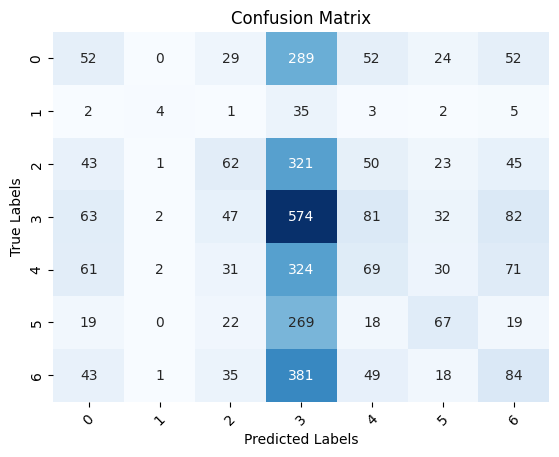

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model_residual.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ['Class 1', 'Class 2', 'Class 3']

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
y_pred = np.argmax(model_residual.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 score:", f1)

113/113 [==============================] - 0s 4ms/step
F1 score: 0.2161110512415355


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.10      0.13       498
           1       0.40      0.08      0.13        52
           2       0.27      0.11      0.16       545
           3       0.26      0.65      0.37       881
           4       0.21      0.12      0.15       588
           5       0.34      0.16      0.22       414
           6       0.23      0.14      0.17       611

    accuracy                           0.25      3589
   macro avg       0.27      0.19      0.19      3589
weighted avg       0.25      0.25      0.22      3589



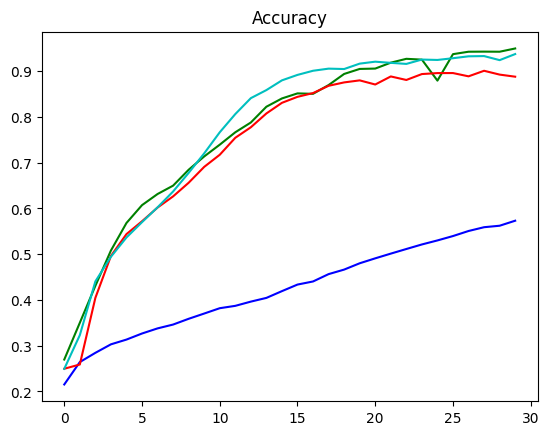

In [ ]:
plt.title("Accuracy")
plt.plot(history_residual.history['accuracy'], 'b')
plt.plot(history_inception.history['accuracy'], 'g')
plt.plot(history_vgg.history['accuracy'], 'r')
plt.plot(history_cnn.history['accuracy'], 'c')

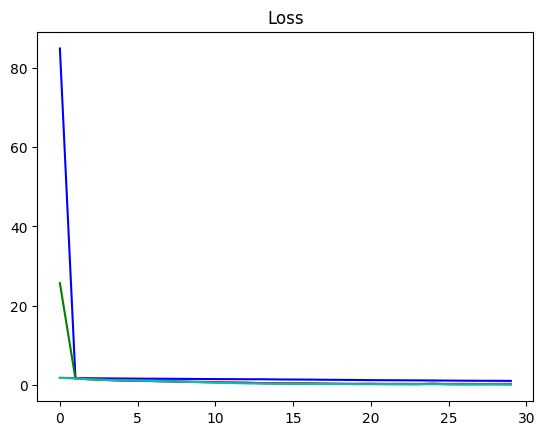

In [ ]:
plt.title("Loss")
plt.plot(history_residual.history['loss'], 'b')
plt.plot(history_inception.history['loss'], 'g')
plt.plot(history_vgg.history['loss'], 'r')
plt.plot(history_cnn.history['loss'], 'c')

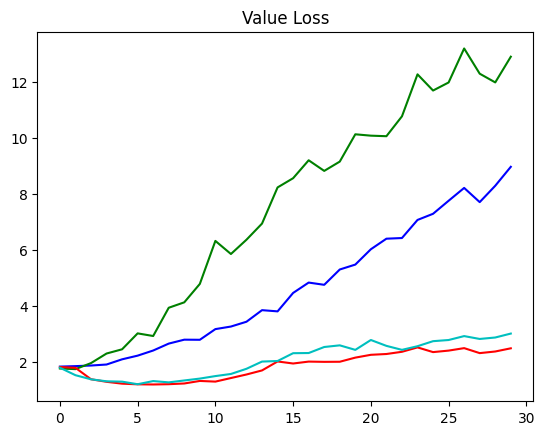

In [ ]:
plt.title("Value Loss")
plt.plot(history_residual.history['val_loss'], 'b')
plt.plot(history_inception.history['val_loss'], 'g')
plt.plot(history_vgg.history['val_loss'], 'r')
plt.plot(history_cnn.history['val_loss'], 'c')

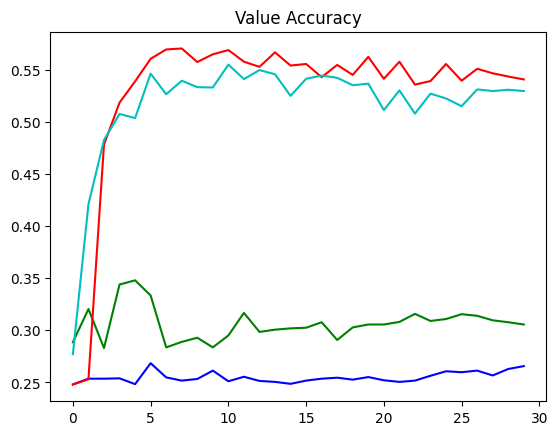

In [ ]:
plt.title("Value Accuracy")
plt.plot(history_residual.history['val_accuracy'], 'b')
plt.plot(history_inception.history['val_accuracy'], 'g')
plt.plot(history_vgg.history['val_accuracy'], 'r')
plt.plot(history_cnn.history['val_accuracy'], 'c')